<a href="https://colab.research.google.com/github/zampolo/prnu/blob/main/fp_prnu_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRNU estimation

Fridrich, J. “Digital Image Forensics”. IEEE Signal Processing Magazine 26, nº 2 (março de 2009): 26–37. https://doi.org/10.1109/MSP.2008.931078.


In [1]:
#@title Import modules
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import cv2 as cv
import pywt
from scipy import signal

from google.colab.patches import cv2_imshow

In [2]:
#@title Define data source
image_path = ''
image_folder = ''

In [72]:
#@title Define functions

def convert_to_gray( im: np.array)->np.array:
  '''Convert an colour image to gray scale.

  Parameters
  ----------
  im: np.array
      Colour image.

  Returns
  -------
  im_gray: np.array
      Gray scale image.

  '''
  im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY) #using OpenCV conversion
  return im_gray.astype(float)




def sigma_sq_for_subband(coef: np.array)->np.array:
  '''Estimate the local variance of a 2D wavelet subband coefficients,
  considering square windows of dimensions 3, 5, 7, and 9.

  Parameters
  ----------
  coef: np.array
      Subband coefficients.

  Results
  -------
  sigma_sq: np.array
      Estimated local variance for a subband.
  '''
  W = [3, 5, 7, 9] # window dimensions
  temp = np.zeros((coef.shape[0], coef.shape[1], len(W))) #temporary variable
  for count, w in enumerate(W):
    #Define the 2D MA filter of dimensions w x w
    h = np.ones((w,w))
    h = h/h.sum()
    # estimate local variance for a w x w window
    temp[:,:,count] = signal.convolve2d(in1 = coef**2 - 4, in2 = h,
                                        mode = 'same')

  sigma_sq = temp.min(axis=2) #calculate the minimum for all windows sizes
  mask = (sigma_sq < 0) #positions where the values are negative
  sigma_sq[mask] = 0 # for that positions, sigma_sq values are zeroed

  return sigma_sq




def estimate_local_variance(coefs: list)->list:
  '''Estimate local variance in wavelet subbands.

  Parameters
  ----------
  coefs: list
      List of wavelet coefficients. Each element of the list corresponds to a
      wavelet subband.

  Results
  -------
  sigma_sq: list
      List of estimated local (pixel) variances. Each element of the list has
      the same dimensions of the corresponding wavelet subband.
  '''
  sigma_sq = [0]

  for wcoef in coefs[1:]:
    temp = []
    for wcoef2 in wcoef:
      temp.append(sigma_sq_for_subband(wcoef2))
    sigma_sq.append(tuple(temp))

  return sigma_sq




def prnu_filter( im: np.array)->np.array:
  '''Low-pass filtering procedure proposed by Fridrich (2009), which used a techninque
  that combines wavelet transform (8-tap Daubechies) and Wiener filtering.

  Parameters
  ----------
  im: np.array
      Input noisy image (it can be in colour or gray scale).

  Returns
  -------
  im_filtered: np.array
      Output image of the filter

  '''
  # 2D wavelet decompostion transform
  coefs = pywt.wavedec2(data = im, wavelet = 'db8', level = 4)

  # In each subband, estimate the local variance of the original noisy-free image
  sigma_sq = estimate_local_variance(coefs) #1 #temporary value

  # Modify coeffs accordinly
  modified_coeffs=[]
  for count, coef in enumerate(coefs):
    if count != 0:
      temp = []
      for count2, coef2 in enumerate(coef):
        correction = ( sigma_sq[count][count2] / ( sigma_sq[count][count2] + 4 ) )
        temp.append(coef2 * correction) # sigma_0 = 2

      modified_coeffs.append(tuple(temp))
    else:
      modified_coeffs.append(coef) # restoring approximation subband

  # Apply the inverse wavelet transform to modified coeffs
  im_filtered = pywt.waverec2(coeffs = modified_coeffs, wavelet = 'db8')

  return im_filtered




def prnu_estimation( folder: str )->np.array:
  '''Estimator for the photo-response non-uniformity (PRNU) of an image
  acquisition system, proposed by Fridrich (2009).

  Parameters
  ----------
  folder: str
      The complete path of a folder that contains the training photos.

  Returns
  -------
  k: np.array
      The estimated PRNU matrix.
  '''
  # List with all the image files (complete path) in 'folder'
  im_files = [f for f in listdir( folder ) if isfile(join(folder, f))]

  for im_fname in im_files:
    im = cv.imread(im_fname)
    i = convert_to_gray( im ) # Convert to gray scale (i)
    i_hat = prnu_filter(i) # Filter the training image (i_hat)
    w = i - i_hat # Calculate the noise image (w)
    k_num += w*i # Estimate the PRNU numerator (k_num)
    k_den += i**2 # Estimate the PRNU denominator (k_den)

  # Estimate the PRNU
  k = k_num/k_den
  return k

In [4]:
#@title Testing functions
im_file = '/content/drive/MyDrive/projetos/full_professor/test_images/camara_pequena.jpeg'
im = cv.imread(im_file)
im_gray = convert_to_gray(im)

In [73]:
noise = np.random.normal(loc=0,scale=4,size=im_gray.shape)
im_gray2 = cv.add(im_gray, noise)
im_gray2 = im_gray

In [74]:
coefs = pywt.wavedec2(data = im_gray2, wavelet = 'db8', level = 4)

In [75]:
im_denoised = prnu_filter(im_gray2)

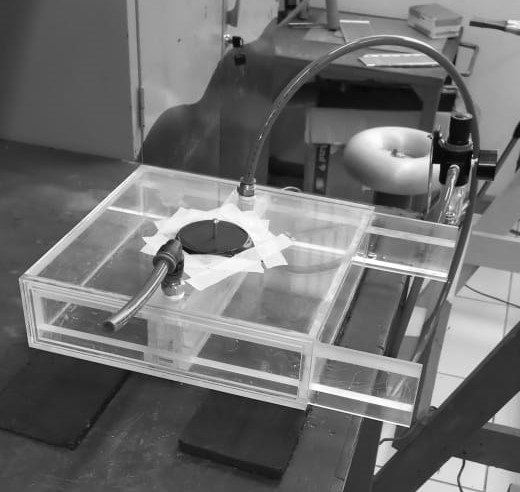

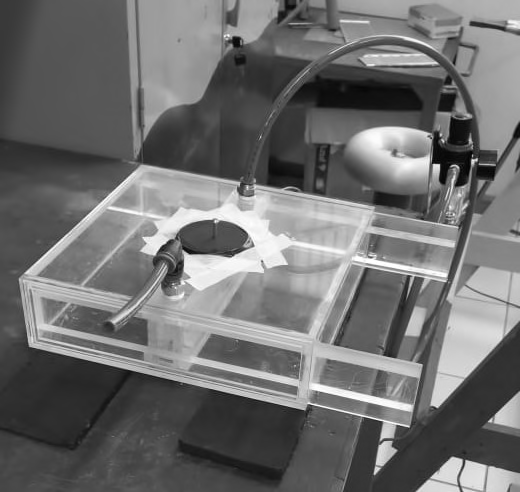

In [76]:
cv2_imshow(im_gray2)
cv2_imshow(im_denoised)


In [71]:
err = im_gray2 - im_denoised
mse = np.mean(err**2)
print(mse)

0.9789704557203606
